In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# get file path from config
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from config import BASE_PATH

In [4]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
fp = os.path.join(BASE_PATH,"dataset","user_pay.txt")
df = pd.read_csv(fp,header=None, engine='c', sep=',')
df.columns = ["user_id", "shop_id", "datetime"]

In [5]:
#print df[(df["datetime"]>="2016-09-17") & (df["datetime"]<"2016-09-18")]
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['datetime'].dt.date)
print df.head()

    user_id  shop_id            datetime       date
0  22127870     1862 2015-12-25 17:00:00 2015-12-25
1   3434231     1862 2016-10-05 11:00:00 2016-10-05
2  16955285     1862 2016-02-10 15:00:00 2016-02-10
3  13799128     1862 2016-01-13 14:00:00 2016-01-13
4  13799128     1862 2016-07-05 12:00:00 2016-07-05


In [6]:
df_grp_by_day = df.groupby(['shop_id', 'date']).size()
print df_grp_by_day.head()

shop_id  date      
1        2015-10-10    188
         2015-10-11    272
         2015-10-12    257
         2015-10-13    239
         2015-10-14    277
dtype: int64


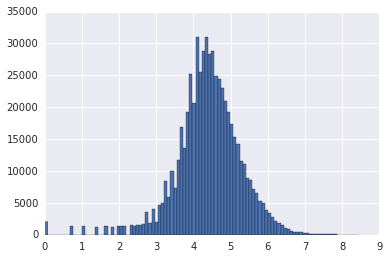

In [7]:
plt.hist(np.log(df_grp_by_day),bins=100)
plt.show()
# per shop per day frequency

取shop_id 为100的店进行研究
参考blog:
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [42]:
shop_slice = np.log(df_grp_by_day[100]["2015-01-01":"2016-09-01"])

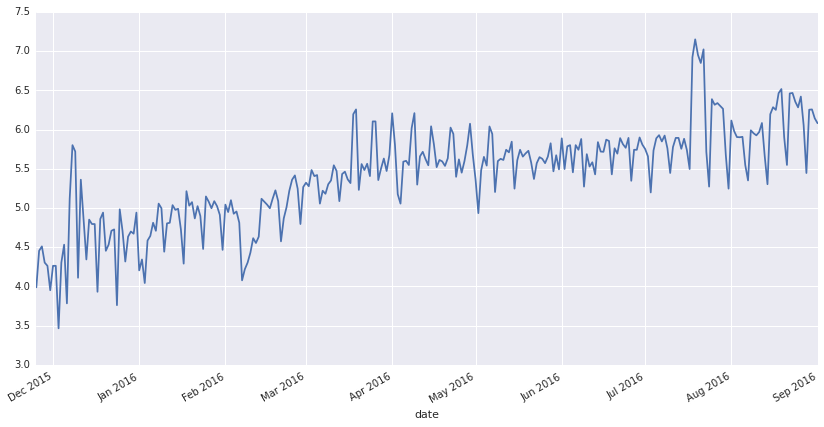

In [43]:
plt.figure(figsize=(14, 7))
shop_slice.plot()

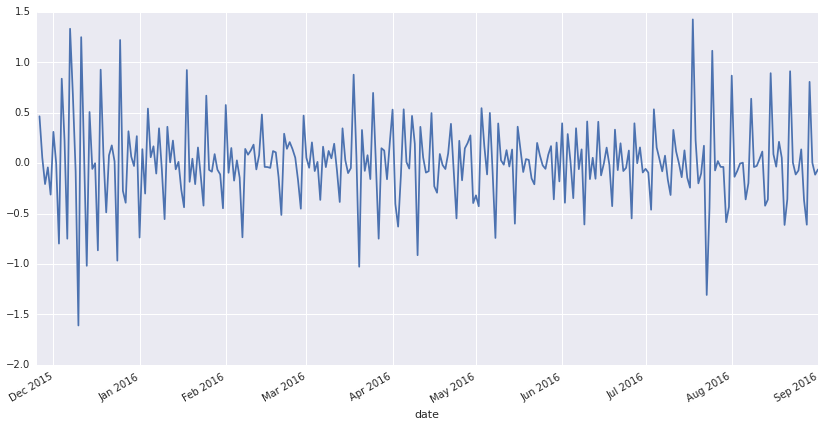

In [44]:
shop_slice_diff1 = shop_slice-shop_slice.shift(1)
plt.figure(figsize=(14, 7))
shop_slice_diff1.plot()

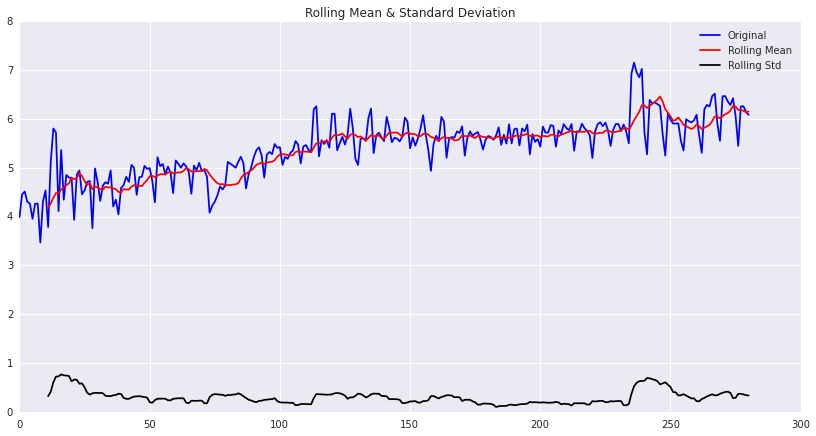

Results of Dickey-Fuller Test:
Test Statistic                  -0.888756
p-value                          0.791653
#Lags Used                      14.000000
Number of Observations Used    266.000000
Critical Value (5%)             -2.872468
Critical Value (1%)             -3.455175
Critical Value (10%)            -2.572593
dtype: float64


In [49]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    plt.figure(figsize=(14, 7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

test_stationarity(shop_slice)

                freq
date                
2015-11-25  3.988984
2015-11-26  4.454347
2015-11-27  4.510860
2015-11-28  4.304065
2015-11-29  4.262680


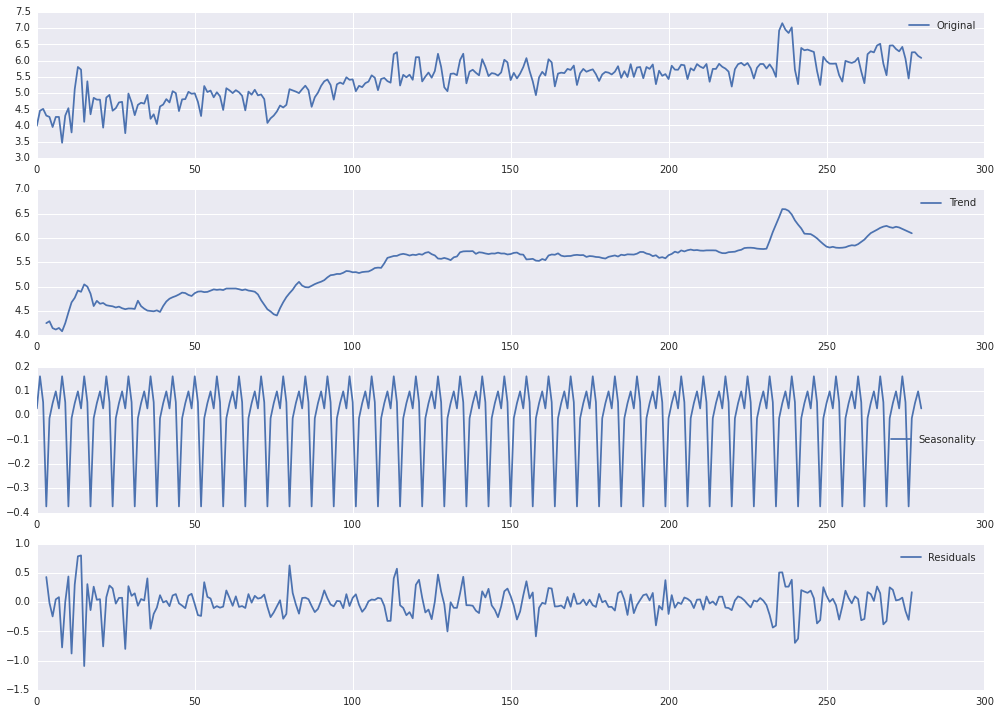

In [46]:
# You must specify a freq or x must be a pandas object with a timeseries index
shop_slice_df = pd.DataFrame(data={"freq": shop_slice.values},index=shop_slice.index)
shop_slice_df.index.to_datetime()
print shop_slice_df.head()

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(shop_slice_df,freq=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(shop_slice_df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [56]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
shop_slice_diff1.fillna(0,inplace=True)
lag_acf = acf(shop_slice_diff1, nlags=20)
lag_pacf = pacf(shop_slice_diff1, nlags=20)
print lag_acf
print lag_pacf

[ 1.         -0.30501241 -0.20558423  0.04722776  0.10297424 -0.32690576
 -0.00409176  0.45295632 -0.15996324 -0.16322333  0.09347253  0.037447
 -0.22993537  0.05361751  0.32242138 -0.11929634 -0.14412384  0.09682584
 -0.04198816 -0.12823653 -0.06015059]
[ 1.         -0.30610174 -0.33185    -0.17142826 -0.01152149 -0.3894562
 -0.38335634  0.19434763  0.02584776 -0.07794614 -0.08280255 -0.09653217
 -0.09123935 -0.10648173  0.073753    0.06934137 -0.01960088 -0.00803939
 -0.10619377 -0.01268589 -0.27752761]
date
2015-11-25    0.000000
2015-11-26    0.465363
2015-11-27    0.056512
2015-11-28   -0.206794
2015-11-29   -0.041385
2015-11-30   -0.311436
2015-12-01    0.311436
2015-12-02    0.000000
2015-12-03   -0.796944
2015-12-04    0.838329
2015-12-05    0.228534
2015-12-06   -0.748410
2015-12-07    1.333804
2015-12-08    0.684125
2015-12-09   -0.081807
...
2016-08-18    0.212684
2016-08-19    0.053083
2016-08-20   -0.612309
2016-08-21   -0.356286
2016-08-22    0.912392
2016-08-23    0.0062

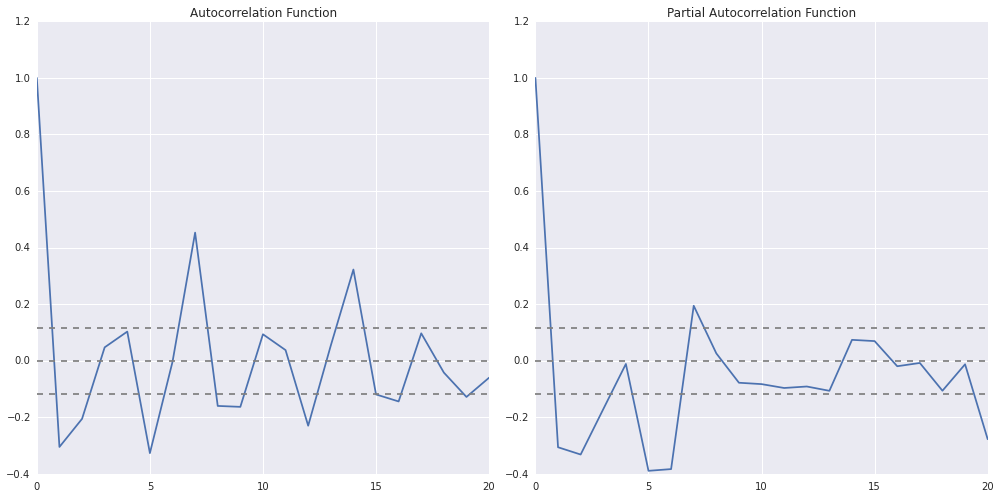

In [57]:
#Plot ACF: 
plt.figure(figsize=(14, 7))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shop_slice_diff1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(shop_slice_diff1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shop_slice_diff1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(shop_slice_diff1)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

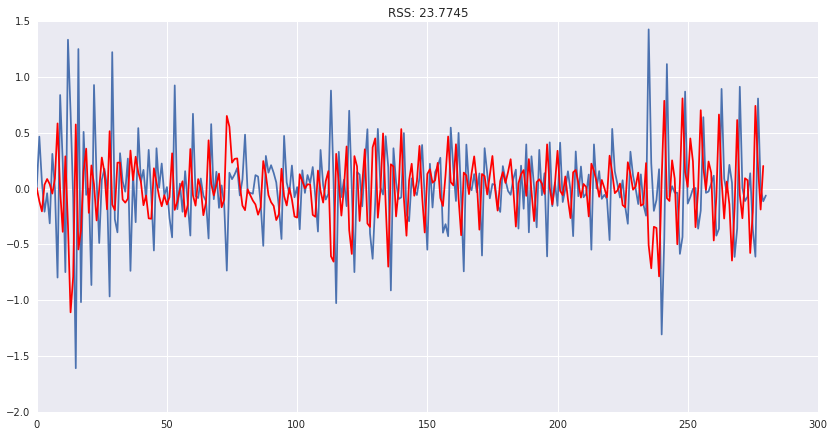

In [82]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(shop_slice_df, order=(6, 1, 6))  
results_ARIMA = model.fit(disp=-1,maxiter=10000) 
plt.figure(figsize=(14, 7))
plt.plot(shop_slice_diff1)
plt.plot(results_ARIMA.fittedvalues, color='red') 
plt.title('RSS: %.4f'% sum(((results_ARIMA.fittedvalues-shop_slice_diff1)[1:])**2))

In [67]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()


date
2015-11-26    0.006467
2015-11-27   -0.111755
2015-11-28   -0.203857
2015-11-29    0.034878
2015-11-30    0.085929
dtype: float64


In [68]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

date
2015-11-26    0.006467
2015-11-27   -0.105288
2015-11-28   -0.309145
2015-11-29   -0.274267
2015-11-30   -0.188338
dtype: float64


In [73]:
predictions_ARIMA_log = pd.Series(shop_slice_df.ix[0].values, index=shop_slice_df.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2015-11-25    3.988984
2015-11-26    3.995451
2015-11-27    3.883697
2015-11-28    3.679839
2015-11-29    3.714717
dtype: float64

/Library/Python/2.7/site-packages/pandas/core/frame.py:3083: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


TypeError: unsupported operand type(s) for +: 'int' and 'str'

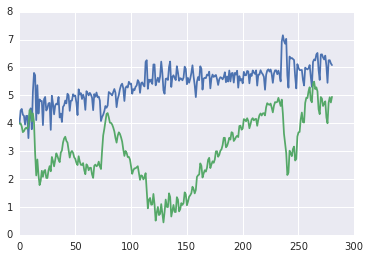

In [74]:
plt.plot(shop_slice_df)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_log-shop_slice_df)**2)/len(ts)))